In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
# label_folder = r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\label\custom'
# image_folder = r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\image\official'

label_folder = r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\label\custom'
image_folder = r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\image\official'

In [3]:
# def get_patches_and_loc(ltwh,map_size):
#     l,t,w,h = ltwh*map_size
    
#     r = l+w
#     cx = (l+r)/2
    
#     b = t+h
#     cy = (t+b)/2
    
#     L = int(l)
#     Cx = int(cx)
#     T = int(t)
#     R = int(r)
#     Cy = int(cy)
#     B = int(b)
    
#     #create center-ness patch
#     horizon = np.concatenate([np.arange(L+1,Cx+1),np.array([cx]),np.arange(Cx+1,R+1)])
#     horizon = np.fmin(horizon-l,r-horizon)/np.fmax(horizon-l,r-horizon)
#     vertical = np.concatenate([np.arange(T+1,Cy+1),np.array([cy]),np.arange(Cy+1,B+1)])
#     vertical = np.fmin(vertical-t,b-vertical)/np.fmax(vertical-t,b-vertical)
#     centerness = np.sqrt(horizon*vertical[:,None])
    
#     #create ground truth center patch
#     gt_center = np.zeros_like(centerness,dtype=float)
#     gt_center[Cy-T,Cx-L] = 1.
    
#     #create determine patch
#     grid_center_coor = np.stack(np.broadcast_arrays((np.arange(L,R+1)+0.5),(np.arange(T,B+1)+0.5)[:,None]),axis=-1)/map_size
#     grid_center_coor = grid_center_coor[:,:,None,:]
#     bbox_rect_coor = np.array([[l,t],[r,t],[r,b],[l,b]])/map_size
#     bbox_rect_coor = bbox_rect_coor[None,None,:,:]
#     determine = np.max(np.abs(grid_center_coor-bbox_rect_coor)*2,axis=-1)
#     determine = np.max(determine,axis=-1)
    
    
    
#     return L,R,T,B,centerness,gt_center,determine


In [3]:
def get_patches_and_loc(category,ltwh,polygon,map_size):
    l,t,w,h = ltwh*map_size
    
    r = l+w
    cx = (l+r)/2
    
    b = t+h
    cy = (t+b)/2
    
    L = int(l)
    Cx = int(cx)
    T = int(t)
    R = int(r)
    Cy = int(cy)
    B = int(b)
    
    #create determine patch
    grid_center_coor = np.stack(np.broadcast_arrays((np.arange(L,R+1)+0.5),(np.arange(T,B+1)+0.5)[:,None]),axis=-1)/map_size
    grid_center_coor = grid_center_coor[:,:,None,:]
    bbox_rect_coor = np.array([[l,t],[r,t],[r,b],[l,b]])/map_size
    bbox_rect_coor = bbox_rect_coor[None,None,:,:]
    determine = np.max(np.abs(grid_center_coor-bbox_rect_coor)*2,axis=-1)
    determine = np.max(determine,axis=-1)
    
    #create center-ness patch
    horizon = np.concatenate([np.arange(L+1,Cx+1),np.array([cx]),np.arange(Cx+1,R+1)])
    horizon = np.fmin(horizon-l,r-horizon)/np.fmax(horizon-l,r-horizon)
    vertical = np.concatenate([np.arange(T+1,Cy+1),np.array([cy]),np.arange(Cy+1,B+1)])
    vertical = np.fmin(vertical-t,b-vertical)/np.fmax(vertical-t,b-vertical)
    centerness = np.sqrt(horizon*vertical[:,None])
    centerness = centerness[:,:,None]
    
    #create ground truth center patch
    gt_center = np.zeros_like(determine,dtype=float)
    gt_center[Cy-T,Cx-L] = 1.
    gt_center = gt_center[:,:,None]
    
    #create category patch
    category = np.full_like(determine,category,dtype=float)
    category = category[:,:,None]
    
    #create cxcywh patch
    cxcy = ltwh[:2] + ltwh[2:]/2
    wh = np.tile(ltwh[2:],(determine.shape[0],determine.shape[1],1))
    grid_center_coor = np.squeeze(grid_center_coor)
    cxcy_offset = cxcy - grid_center_coor
    cxcywh = np.concatenate([cxcy_offset,wh],axis=-1)
    
    #create polygon points offset patch
    rectangle = np.array([[l,t],[r,t],[r,b],[l,b]])/map_size
    polygon_points_offset = polygon - rectangle
    polygon_points_offset = polygon_points_offset.reshape(-1)
    polygon_points_offset = np.tile(polygon_points_offset,(determine.shape[0],determine.shape[1],1))
    
    label = np.concatenate([centerness,gt_center,category,cxcywh,polygon_points_offset],axis=-1)
    return L,R,T,B,determine,label

In [8]:
# label_id = 2908
label_id = 2908
label_path = pathlib.Path(label_folder,f'img_{label_id}.json')
label = json.loads(label_path.read_text(encoding='utf8'))
image_byte = tf.io.read_file(pathlib.Path(image_folder,label['ImageName']).as_posix())
image = tf.image.decode_jpeg(image_byte)
image = tf.image.convert_image_dtype(image,tf.float32)
image = tf.image.resize(image,(1024,1024))

image_size = 1024
map_size = 128
determine_range = [16,32,64,128,256,512,1024]

determine_range = [(determine_range[i-1]+1,d) if i != 0 else (0,d) for i,d in enumerate(determine_range)]
determine_range = [(s/image_size,e/image_size) for s,e in determine_range]

categories = np.array([b['type'] for b in label['bboxes']])
rectangles_ltwh = np.array([b['rectangle']['ltwh'] for b in label['bboxes']])
rectangles_ltwh[:,2:] = rectangles_ltwh[:,2:]-1e-4
polygons_points =  np.array([b['polygon']['points'] for b in label['bboxes']])

# [layers_count,map_size,map_size,
# [center-ness,
# gt_center,
# category,
## the following features should be normalized by the vision field it belongs to
## four features for 
# rectangle_center_offset_x_coor,
# rectangle_center_offset_y_coor,
# rectange_width,
# rectangle_height,
# polygon_lt_to_rectangle_lt_offset_x_coor
# polygon_lt_to_rectangle_lt_offset_y_coor
# polygon_rt_to_rectangle_rt_offset_x_coor
# polygon_rt_to_rectangle_rt_offset_y_coor
# polygon_rb_to_rectangle_rb_offset_x_coor
# polygon_rb_to_rectangle_rb_offset_y_coor
# polygon_lb_to_rectangle_lb_offset_x_coor
# polygon_lb_to_rectangle_lb_offset_y_coor
# ]]
label = np.zeros([len(determine_range),map_size,map_size,1+1+1+4+4*2],dtype=float)

# centerness = [np.zeros((map_size,map_size)) for _ in range(len(determine_range))]
# gt_center = [np.zeros((map_size,map_size)) for _ in range(len(determine_range))]

for category,ltwh,points in zip(categories,rectangles_ltwh,polygons_points):
#     L, Cx, R, T, Cy, B, centerness_patch, determine_patch = get_patches_and_loc(ltwh, map_size)
    L,R,T,B,determine_patch,label_patch = get_patches_and_loc(category, ltwh, points, map_size)
    for i,dr in enumerate(determine_range):
        in_determine_range = (dr[0]<=determine_patch)&(determine_patch<=dr[1])
        greater_centerness = (label_patch[:,:,0]>label[i,T:B+1,L:R+1,1])
        mask = in_determine_range&greater_centerness
        mask = mask[:,:,None]
        label[i,T:B+1,L:R+1,:] = np.where(
            mask,
            label_patch,
            label[i,T:B+1,L:R+1,:])

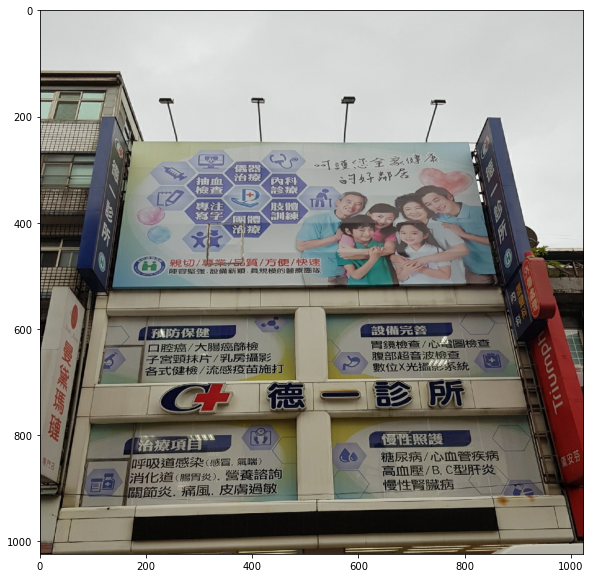

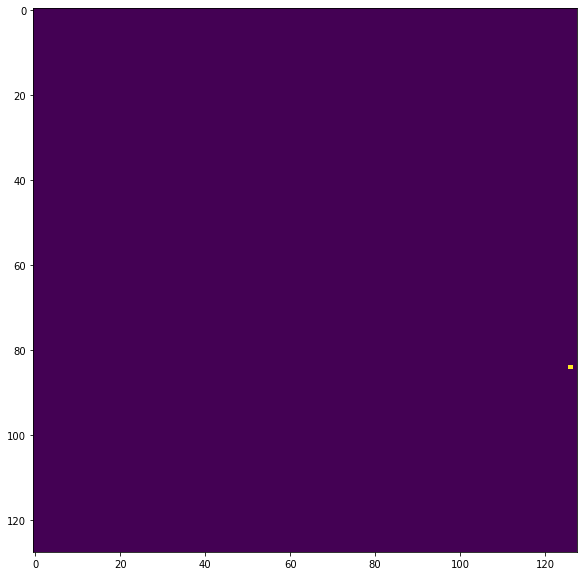

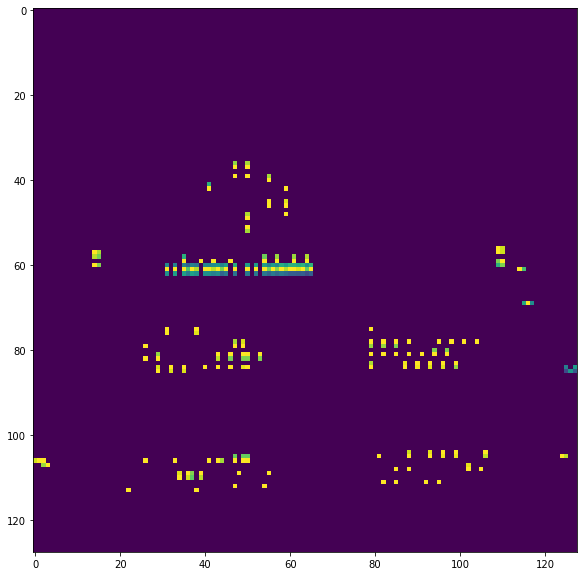

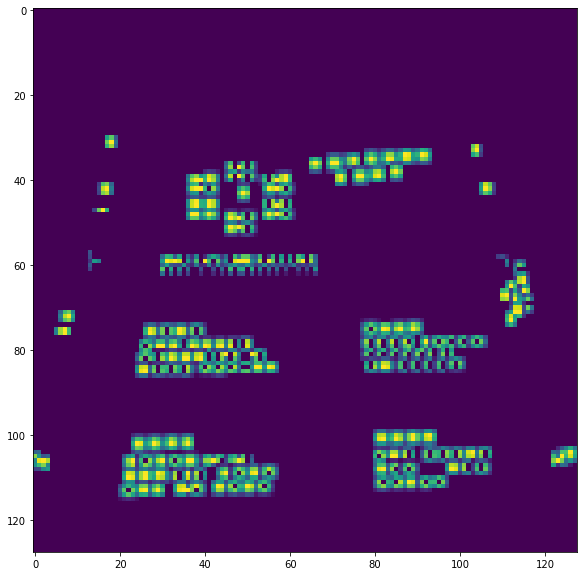

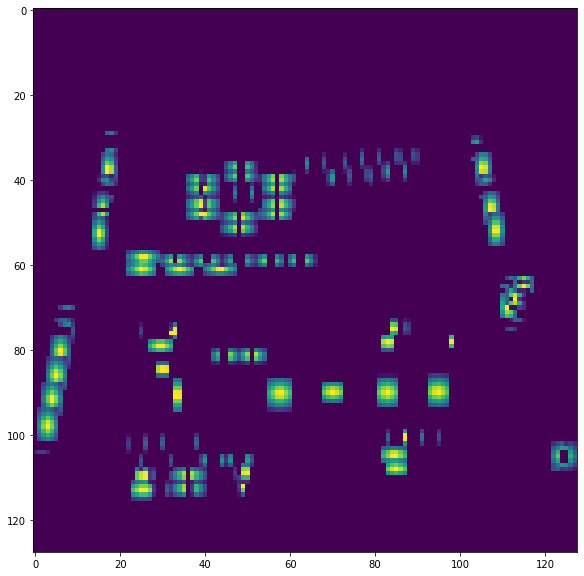

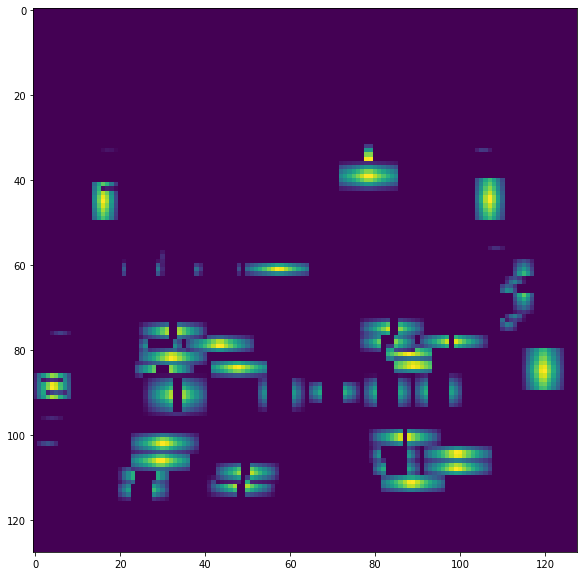

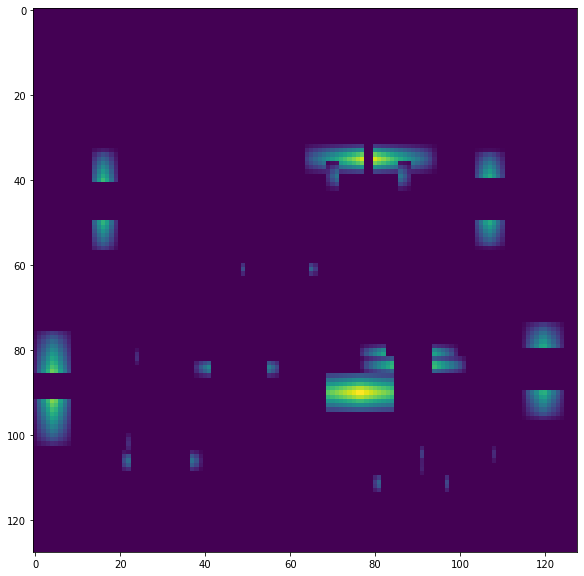

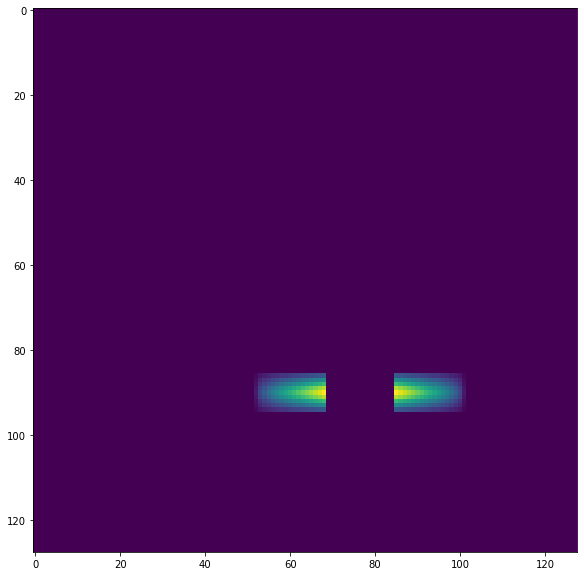

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()
for c in label[:,:,:,0]:
    plt.figure(figsize=(10,10))
    plt.imshow(c)
    plt.show()

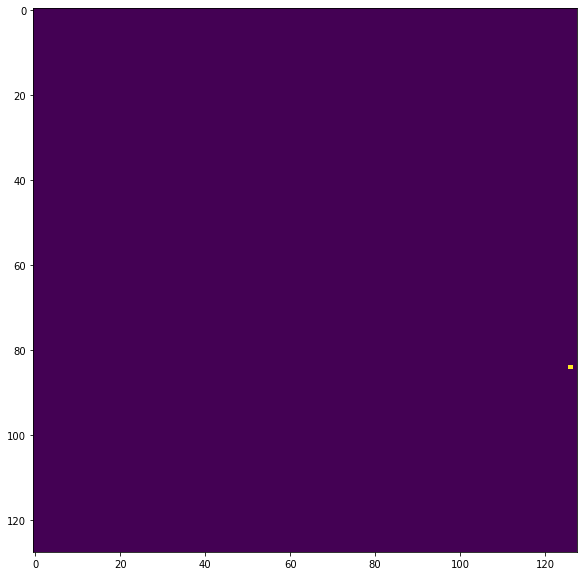

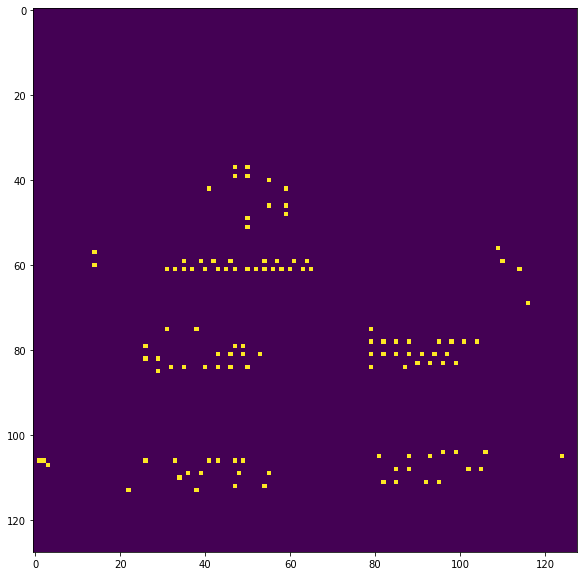

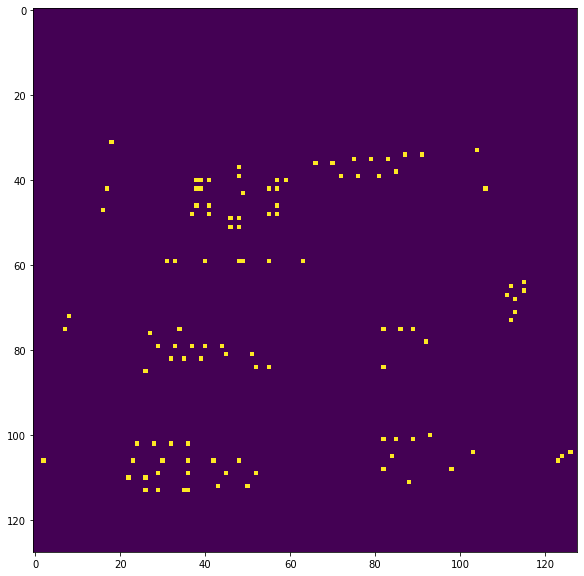

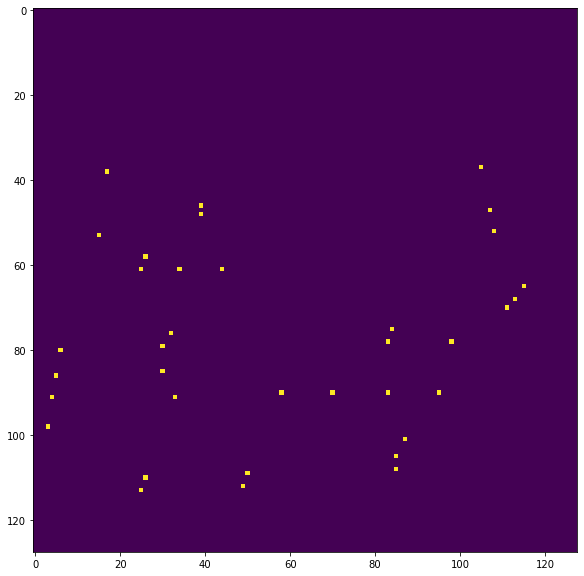

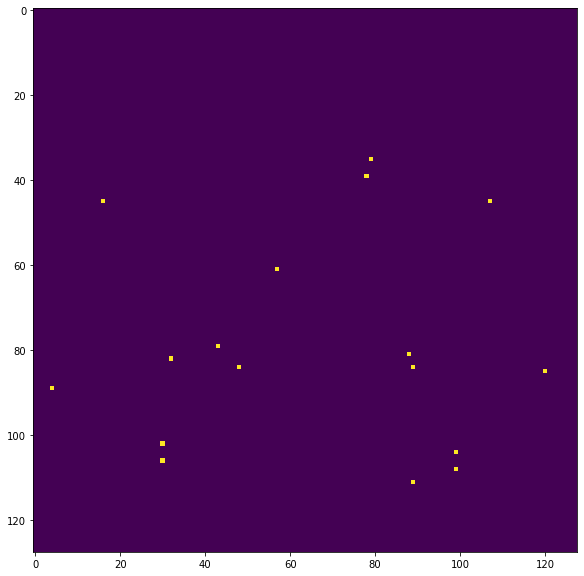

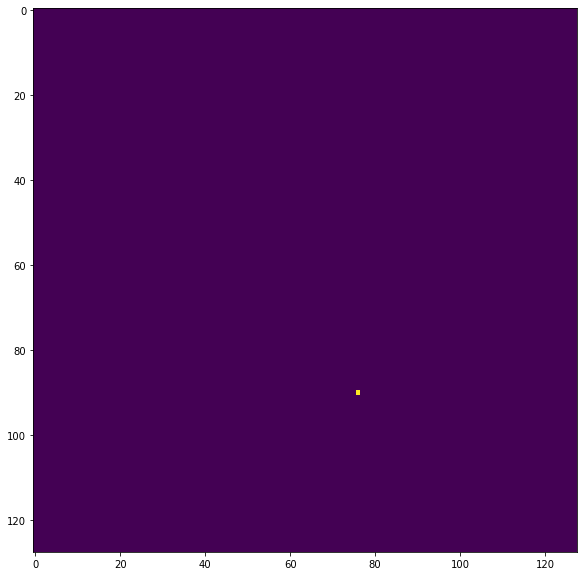

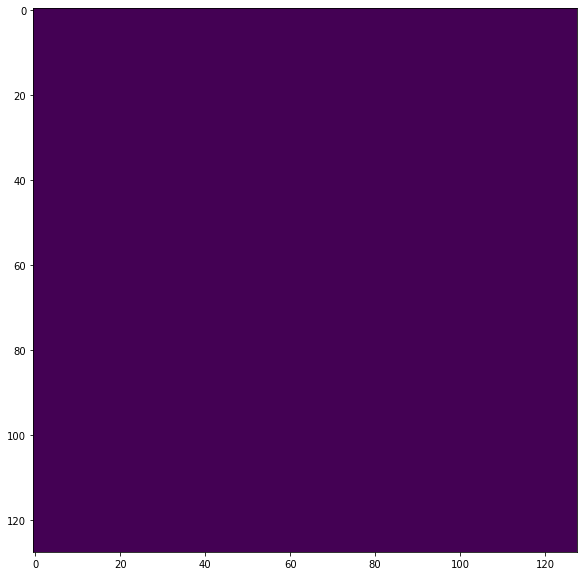

In [15]:
for c in label[:,:,:,1]:
    plt.figure(figsize=(10,10))
    plt.imshow(c)
    plt.show()

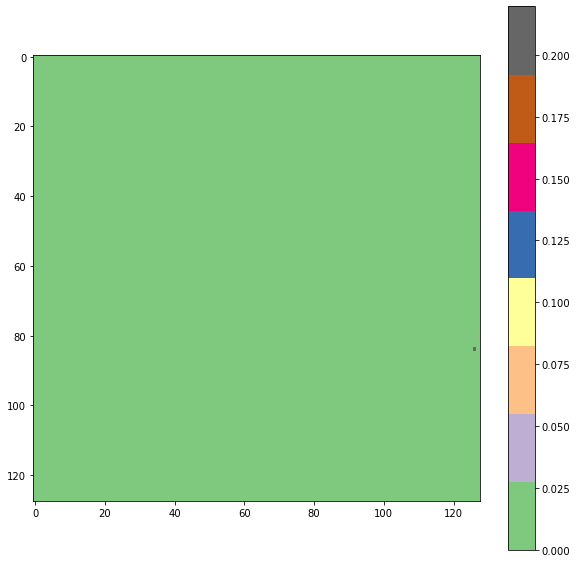

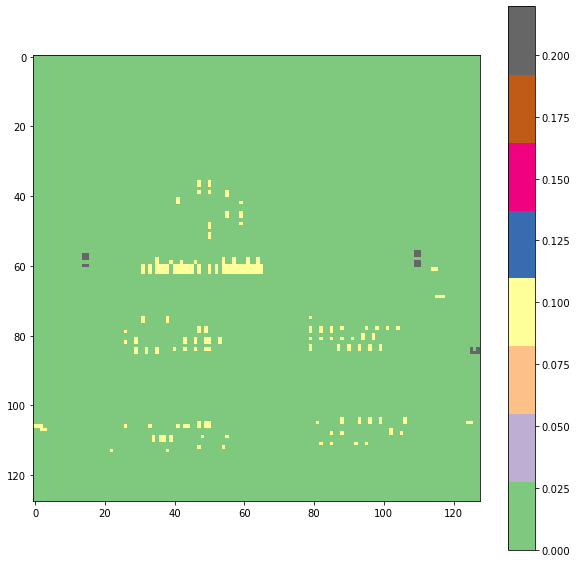

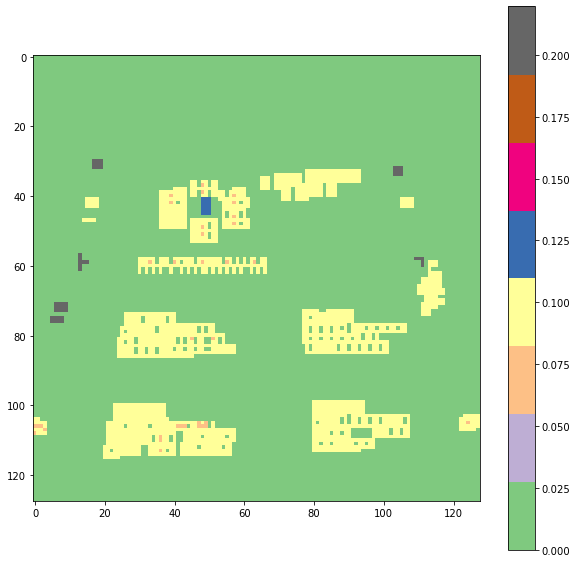

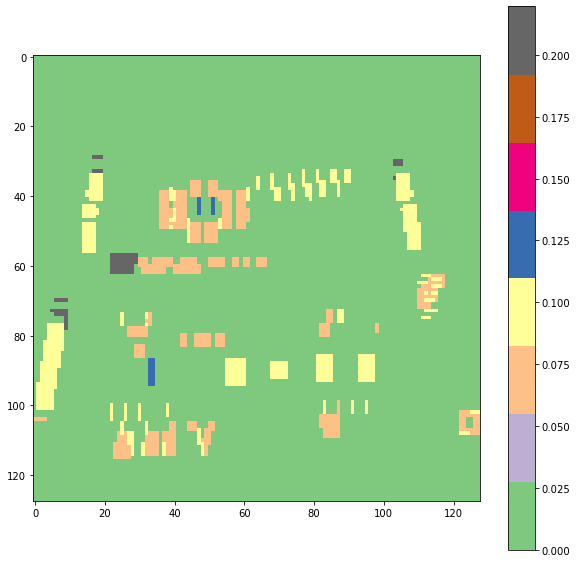

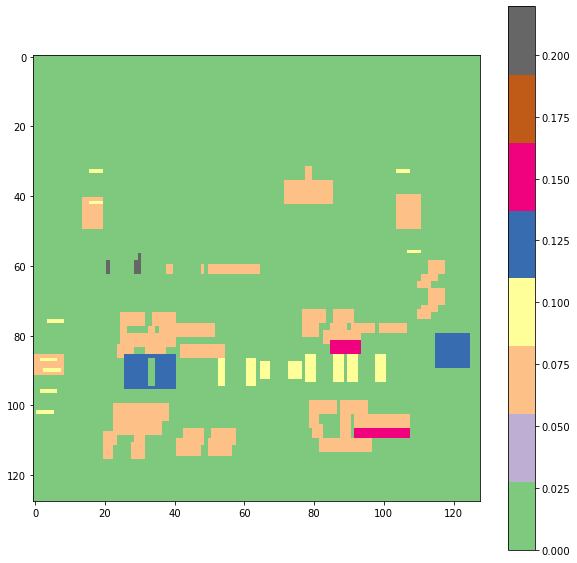

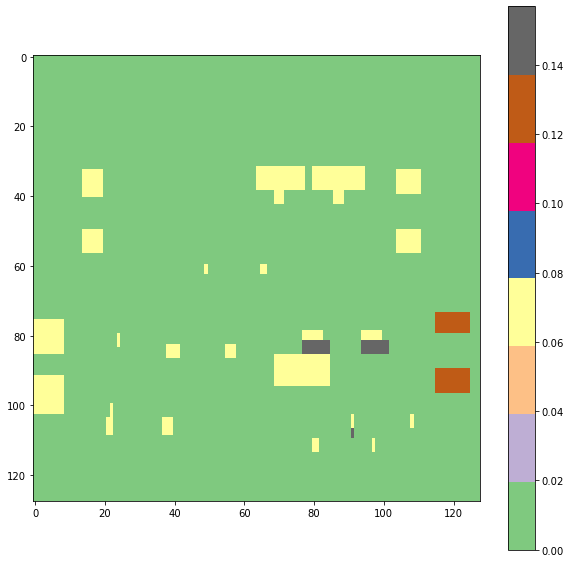

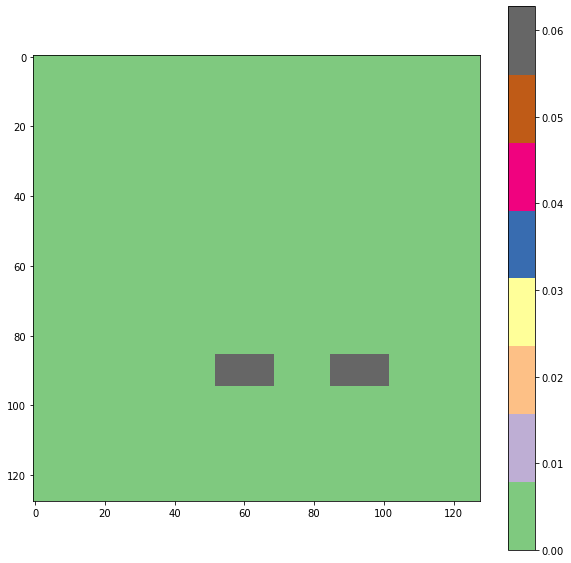

In [14]:
for c in label[:,:,:,2]:
    plt.figure(figsize=(10,10))
    plt.imshow(c/255*8,cmap=plt.get_cmap('Accent'))
    plt.colorbar()
    plt.show()

In [ ]:
class Inspector:
    def __init__(self,label,image):
        self.image = image
        self.label = label
    def layer(self,i):
        self.inspect_count = 0
        grid_center_coor = np.stack(np.broadcast_arrays(np.arange(self.label.shape[1])+0.5),(np.arange(label.shape[2])+0.5)[:,None],axis=-1)
        grid_center_coor = grid_center_coor/np.array([label.shape[1],label.shape[0]])
        self.inspect_layer = np.concatenate([self.label[i],grid_center_coor])
        self.inspect_content = self.inspect_layer[self.inspect_layer[:,:,0]!=0]
        return self
    def show(self,examples):
        labels = self.inspect_content[self.inspect_count:self.inspect_count+examples]
        for label in labels:
            label_center = label[-2:]
            centerness = label[0]
            gt_center = label[1]
            category = label[2]
            lt = label[[3,4]] + label_center
            wh = label[[5,6]]
            rectangle = 
            polygan
        
        self.inspect_count += examples

In [ ]:
ins = Inspector(label,image)

In [23]:
label[1][label[1,:,:,0]!=0].shape

(256, 15)